# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Strategy using the GARCH predicted volatility

As you have learnt in the previous units, the GARCH model is used to predict volatility. The volatility prediction is compared to the historical volatility at the current time step.

In this notebook, you will perform the following steps:

1. [Read the data](#read)
1. [Calculate the annualised historical volatility](#vol)
1. [GARCH volatility forecasting](#garch)
1. [Generate the trading signals for the strategy](#trade)
1. [Analyse the strategy performance](#graph)

## Import the necessary libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# For implementing the ARCH model
from arch import arch_model

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("..")
from data_modules.tsa_functions_quantra import analyse_strategy

<a id='read'></a> 
## Read the data

In [2]:
# The data is stored in the directory 'data_modules'
path = '../data_modules/'
# Read the csv file using read_csv method of pandas
data = pd.read_csv(path + 'SP500_VXX_price_2017_2020_GARCH.csv', index_col=0)
data.index = pd.to_datetime(data.index, format = "%d-%m-%Y")
data.tail()

,SP500,VIX,VXX
Date,,,
2020-12-21,3694.92,25.16,18.44
2020-12-22,3687.26,24.23,18.11
2020-12-23,3690.01,23.31,17.38
2020-12-24,3703.06,21.53,16.88
2020-12-28,3735.36,21.70,16.82


<a id='vol'></a> 
## Calculate the annualised historical volatility
The annualised historical volatility is calculated by taking the daily volatility of the last 14 days and then annualised.

In [3]:
data['log_returns'] = np.log(data['SP500'].pct_change() + 1)*100

# Annualised volatilty
data['actual_historical_volatility'] = data['log_returns'].rolling(14).std() * ((252)**0.5)

# Print the last 5 rows
data.round(2).tail()

,SP500,VIX,VXX,log_returns,actual_historical_volatility
Date,,,,,
2020-12-21,3694.92,25.16,18.44,-0.39,8.82
2020-12-22,3687.26,24.23,18.11,-0.21,8.88
2020-12-23,3690.01,23.31,17.38,0.07,8.87
2020-12-24,3703.06,21.53,16.88,0.35,8.16
2020-12-28,3735.36,21.70,16.82,0.87,8.86


<a id='garch'></a> 
## GARCH volatility forecasting

As you have learnt in the previous notebook, the model is fit to obtain the GARCH predicted volatility.

<i>  <span style="color:#FFFF00; background:#00C000"> <b> Running the below cell will take some time. Please be patient. You can also download this notebook from the last section of this course and run it on your local system.</i>

In [4]:
# Function to predict the volatility of 1 day
def predict_volatility(hist_returns_data):
    # define model
    gm = arch_model(hist_returns_data, vol='GARCH', p=1, q=1, dist='skewt')

    # fit the model
    gm_fit = gm.fit(disp='off')

    # make forecast
    forecasted_variance = gm_fit.forecast(horizon=1).variance.values[-1]
    return (forecasted_variance**0.5) * (252**0.5)

data['GARCH_predicted_volatility'] = data['log_returns'].rolling(252).apply(
    predict_volatility, raw=True)

<a id='trade'></a> 
## Generate the trading signals for the strategy

VXX ETN is bought if the predicted volatility is greater than the historical volatility, and vice versa.

$$\text{Buy VXX if } \quad GARCH\_predicted\_volatility > actual\_historical\_volatility \;  \text{at the current time}$$ 

$$\text{Sell VXX if } \quad GARCH\_predicted\_volatility < \text{current } actual\_historical\_volatility \; \text{at the current time}$$

![Strategy Logic](https://d2a032ejo53cab.cloudfront.net/Glossary/eTyG2hmj/GARCHNB.jpg)

In [5]:
data['signal'] = np.where(data['GARCH_predicted_volatility'] > data['actual_historical_volatility'], 1, -1)
data['strategy_returns'] = data['VXX'].pct_change() * data.signal.shift(1) 
data.dropna(inplace=True)

<a id='graph'></a> 
## Analyse the strategy performance
The strategy performance is analysed using the `analyse_strategy` function from the `tsa_functions_quantra` file.

The Sharpe Ratio is 1.24
The cumulative return is 303.65%
The maximum drawdown is -48.80%


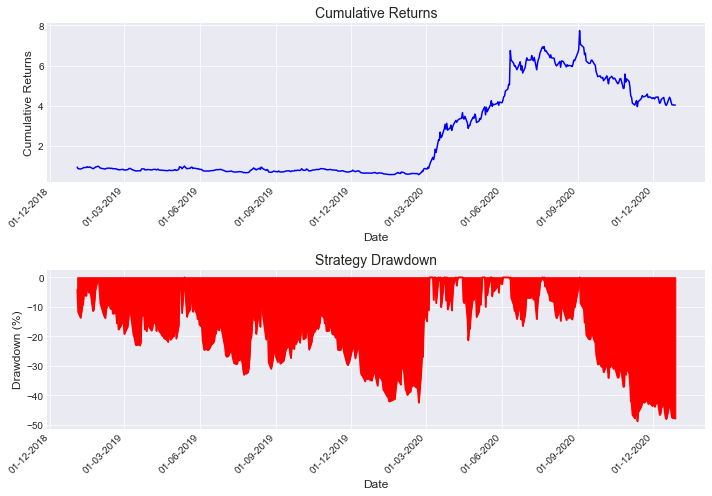

In [6]:
analyse_strategy(data['strategy_returns'])

The GARCH strategy implemented here has large drawdowns because the VXX returns are tagged to the VIX Futures returns. The VIX Futures inherently are very volatile and so large drawdowns are seen.

## Tweak the code
You can tweak the code in the following ways:

1. Use different asset other than VXX and see how the strategy performs
1. Use a different order of the GARCH model (p,q). The optimal lag order can be chosen by taking the order of the PACF plot of the squared returns
1. Use a different lookback for the volatility calculation and the GARCH model fitting

In the next section, you will learn about the limitations of time series modelling.
<br><br>